# Plot standalone Pythia production

First define an accumulator.

In [ ]:
%%bash
for i in `seq 1 5`;
do 
    xrdcp -f root://cmseos.fnal.gov//store/user/chpapage/pythiaGen/qcd_CP${i}.root .;
    xrdcp -f root://cmseos.fnal.gov//store/user/chpapage/pythiaGen/qcd_CP${i}_down.root .;
    xrdcp -f root://cmseos.fnal.gov//store/user/chpapage/pythiaGen/qcd_CP${i}_up.root .;
done

In [ ]:
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate

ak.behavior.update(candidate.behavior)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nTracks": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("nTracks", "multiplicity", 50, 0, 250),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']

        nTracks = events.nTracks

        output["sumw"][dataset] += len(events)
        output["nTracks"].fill(
            dataset=dataset,
            nTracks=nTracks,
        )

        return output

    def postprocess(self, accumulator):
        return accumulator

Now, use this to run over a file.

In [ ]:
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema

uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource

filename = "qcd_CUETP8M1.root"
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='tree',
    entry_stop=100000,
    metadata={"dataset": "CUETP8M1"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
out = p.process(events)
out

Plot the histogram.

In [ ]:
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ROOT)

ax = plt.gca()

hist.plot1d(
    out['nTracks'],
    ax=ax,
    overlay='dataset',
)
ax.autoscale(axis='x', tight=True)
ax.set_ylim(1, None)
ax.set_yscale('log')

Move to executors.

In [ ]:
fileset = {
    'CUETPM81': [
        'qcd_CUETP8M1.root',
    ],
    'CUETPM81 up': [
        'qcd_CUETP8M1_up.root',
    ],
    'CUETPM81 down': [
        'qcd_CUETP8M1_down.root',
    ]

}

out = processor.run_uproot_job(
    fileset,
    treename="tree",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": BaseSchema,
    },
    #maxchunks=4,
)
out

In [ ]:
ax2 = plt.gca()
ax2.autoscale(axis='x', tight=True)


hist.plot1d(
    out['nTracks'],
    ax=ax2,
    overlay='dataset',
    density=True
)
ax2.set_ylim(1e-5, None)
ax2.set_yscale('log')


In [ ]:
fileset = {
    'CP1': [
        'qcd_CP1.root',
    ],
    'CP2': [
        'qcd_CP2.root',
    ],
    'CP3': [
        'qcd_CP3.root',
    ],
    'CP4': [
        'qcd_CP4.root',
    ],
    'CP5': [
        'qcd_CP5.root',
    ],
    'high': [
        'qcd_high.root',
    ],
}

out = processor.run_uproot_job(
    fileset,
    treename="tree",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": BaseSchema,
    },
    #maxchunks=4,
)
out

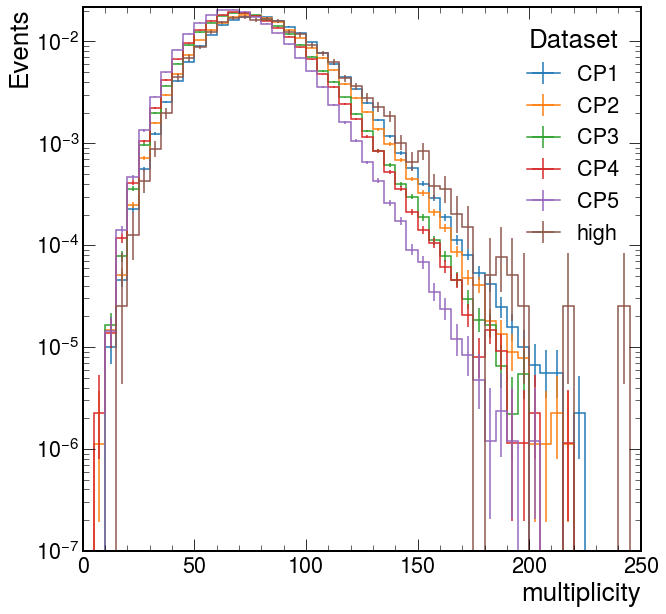

In [8]:
ax3 = plt.gca()
ax3.autoscale(axis='x', tight=True)

hist.plot1d(
    out['nTracks'],
    ax=ax3,
    overlay='dataset',
    density=True
)
ax3.set_ylim(1e-7, None)
ax3.set_yscale('log')